In [166]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import random, os
import seaborn as sns
from glob import glob 
from PIL import Image
import cv2
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix, classification_report

In [167]:
#Import metadata 
df =pd.read_csv('HAM10000_metadata.csv')

## Simple EDA

In [168]:
df.head(25)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


Text(0.5, 1.0, 'Frequency Distribution of Classes')

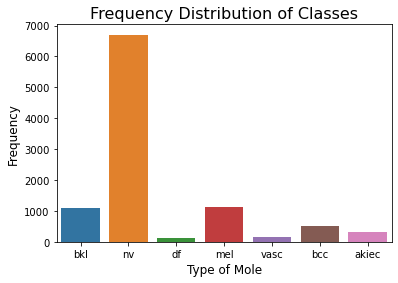

In [169]:
##Frequency distribution of classes:
sns.countplot(x = 'dx', data = df)
plt.xlabel('Type of Mole', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

In [170]:
path = "HAM10000_images/"

In [171]:
#Adding name of image to dataset
df["image_name"] = df['image_id']+ '.jpg'
X = df[["image_name",'dx', 'lesion_id']]
y = X.pop('dx').to_frame()

In [172]:
X.sample(5)

,image_name,lesion_id
6784,ISIC_0025442.jpg,HAM_0002652
2459,ISIC_0025452.jpg,HAM_0004257
6576,ISIC_0029310.jpg,HAM_0006701
8221,ISIC_0031079.jpg,HAM_0003387
3201,ISIC_0028515.jpg,HAM_0006463


In [173]:
y.value_counts()

dx   
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
dtype: int64

### Undersampling for imbalanced dataset

In [176]:
#undersample = RandomUnderSampler(sampling_strategy='majority')
sampling_strategy = {'bkl': 500, 'nv':1500 , 'df': 115, 'mel':500 , 'vasc':142 , 'bcc':514 , 'akiec':327 }
#undersample = RandomUnderSampler(sampling_strategy='majority')
undersample = RandomUnderSampler(sampling_strategy= sampling_strategy)
X,y  = undersample.fit_resample(X,y)

In [177]:
X.shape

(3598, 2)

Text(0.5, 1.0, 'Frequency Distribution of Classes')

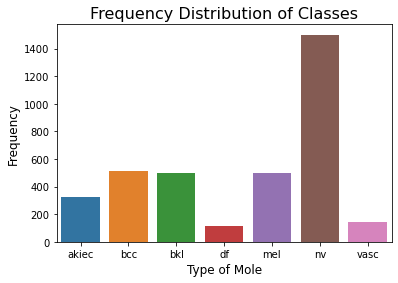

In [178]:
sns.countplot(x = 'dx', data = y)
plt.xlabel('Type of Mole', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

In [179]:
#Splitting dataset
#Reference https://www.youtube.com/watch?v=nuakBf3rBmw, https://www.kaggle.com/code/dhruv1234/ham10000-skin-disease-classification/notebook

X_train, X_test_, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=42)

In [180]:
train = pd.concat([X_train, y_train], axis=1)
val = pd.concat([X_val, y_val], axis=1)
test = pd.concat([X_train, y_train], axis=1)

In [181]:
train.head()

,image_name,lesion_id,dx
29,ISIC_0031108.jpg,HAM_0004809,akiec
1855,ISIC_0032400.jpg,HAM_0006803,mel
2754,ISIC_0031018.jpg,HAM_0005097,nv
1727,ISIC_0024688.jpg,HAM_0001444,mel
3272,ISIC_0031219.jpg,HAM_0004851,nv


In [182]:
encoder = LabelEncoder()
encoder.fit(val['dx'])
name_as_indexes_train = encoder.transform(val['dx'])
val['label'] = name_as_indexes_train

In [183]:
val.head()

,image_name,lesion_id,dx,label
1742,ISIC_0029318.jpg,HAM_0002609,mel,4
3484,ISIC_0025244.jpg,HAM_0000845,vasc,6
3222,ISIC_0033137.jpg,HAM_0005116,nv,5
81,ISIC_0026927.jpg,HAM_0003501,akiec,0
2426,ISIC_0030590.jpg,HAM_0000950,nv,5


In [184]:
encoder = LabelEncoder()
encoder.fit(test['dx'])
name_as_indexes_test = encoder.transform(test['dx'])
test['label'] = name_as_indexes_test

In [185]:
train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range = 10, 
                                     zoom_range = 0.1,
                                     width_shift_range=0.0, height_shift_range=0.00
)
#train_generator = ImageDataGenerator(rescale = 1./255)

In [186]:
train_data = train_generator.flow_from_dataframe(dataframe=train, x_col='image_name', y_col="dx", batch_size=32, directory=path, shuffle =True, class_mode="categorical", target_size=(224,224))
#train_generator.fit(X_train)

Found 2302 validated image filenames belonging to 7 classes.


In [187]:
train_data.image_shape

(224, 224, 3)

In [188]:
test_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range = 10, 
                                     zoom_range = 0.1,
                                     width_shift_range=0.0, height_shift_range=0.02
)
#test_generator = ImageDataGenerator(rescale = 1./255)

In [189]:
test_data = test_generator.flow_from_dataframe(dataframe=test, x_col='image_name', y_col="dx", batch_size=1, directory=path, shuffle=False, class_mode=None, target_size=(224,224))

Found 2302 validated image filenames.


In [190]:
test_data.image_shape

(224, 224, 3)

In [191]:
val_data = test_generator.flow_from_dataframe(dataframe=val, x_col='image_name', y_col="dx", batch_size=64, directory=path, shuffle=False, class_mode="categorical", target_size=(224,224))

Found 576 validated image filenames belonging to 7 classes.


In [193]:
val_data.image_shape

(224, 224, 3)

### Showcase some of the training images

In [194]:
def plot_images(img_array):
    fig, axes = plt.subplots(1,5, figsize=(25,25))
    axes = axes.flatten()
    for img, ax in zip(img_array,axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

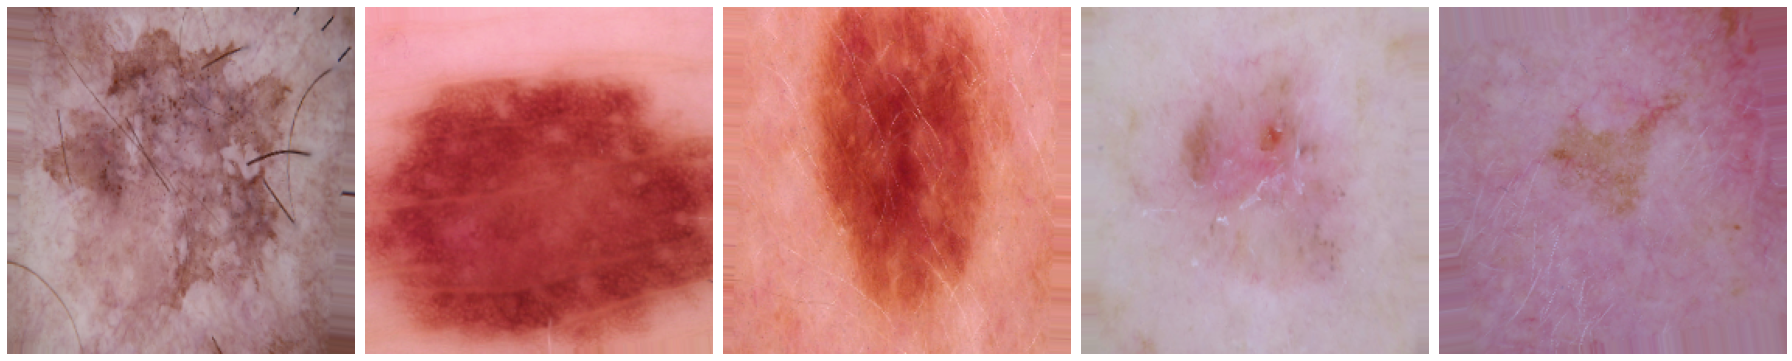

In [195]:
sample_train_images, _ = next(train_data)
plot_images(sample_train_images[:5])

In [196]:
#Using model
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))
# for layer in model.layers:
#     layer.trainable = False

In [197]:
model = Sequential()
model.add(base_model)
model.add(Conv2D(16,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.40))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
#model.add(Dropout(0.4))
#Output layer must match the different outputs from our labels, in this case 7
model.add(Dense(7,activation='sigmoid'))

In [30]:
#learning_control = ReduceLROnPlateau(monitor='val_acc',patience=3, verbose=1, factor=.5, min_lr=0.0001)

In [198]:
#Defining metrics
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
      metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [199]:
sgd = SGD(learning_rate=0.01,clipvalue=0.5)
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=METRICS)

In [200]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 16)          184336    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 16)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 7)                

In [163]:
history=model.fit(train_data,batch_size=128, epochs=5, validation_data=val_data)

Epoch 1/5
201/201 [==============================] - 884s 4s/step - loss: 0.8952 - accuracy: 0.6906 - val_loss: 2.1701 - val_accuracy: 0.6606
Epoch 2/5
201/201 [==============================] - 819s 4s/step - loss: 0.6139 - accuracy: 0.7699 - val_loss: 2.7711 - val_accuracy: 0.6606
Epoch 3/5
201/201 [==============================] - 672s 3s/step - loss: 0.4692 - accuracy: 0.8224 - val_loss: 2.8083 - val_accuracy: 0.6650
Epoch 4/5
201/201 [==============================] - 658s 3s/step - loss: 0.3423 - accuracy: 0.8719 - val_loss: 2.1622 - val_accuracy: 0.6725
Epoch 5/5
201/201 [==============================] - 661s 3s/step - loss: 0.2567 - accuracy: 0.9062 - val_loss: 2.8302 - val_accuracy: 0.6787


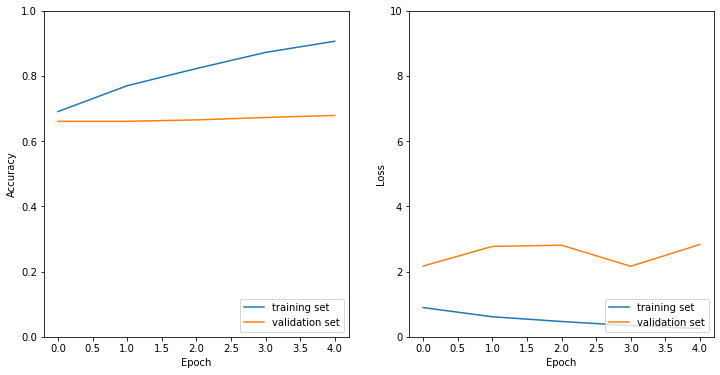

In [166]:
import tensorflow

def plot_history(history):
    """ This helper function takes the tensorflow.python.keras.callbacks.History
    that is output from your `fit` method to plot the loss and accuracy of
    the training and validation set.
    """
    
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].title('Model Accuracy')
    axs[0].plot(history.history['accuracy'], label='training set')
    axs[0].plot(history.history['val_accuracy'], label = 'validation set')
    axs[0].set(xlabel = 'Epoch', ylabel='Accuracy', ylim=[0, 1])
    
    axs[1].title('Model Loss')
    axs[1].plot(history.history['loss'], label='training set')
    axs[1].plot(history.history['val_loss'], label = 'validation set')
    axs[1].set(xlabel = 'Epoch', ylabel='Loss', ylim=[0, 10])
    
    axs[0].legend(loc='lower right')
    axs[1].legend(loc='lower right')
    
plot_history(history)

In [168]:
loss, acc = model.evaluate(test_data, verbose=0)
# print('Test accuracy: ', score)
print('Test loss:', loss)
print('Test accuracy:', acc)

6409/6409 [==============================] - 88s 14ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Test accuracy:  [0.0, 0.0]


In [169]:
history.history

{'loss': [0.8951676487922668,
  0.6139388680458069,
  0.469226211309433,
  0.34229543805122375,
  0.2566726803779602],
 'accuracy': [0.6905913352966309,
  0.7698549032211304,
  0.8224372267723083,
  0.871898889541626,
  0.9062256217002869],
 'val_loss': [2.170067310333252,
  2.7710628509521484,
  2.808253288269043,
  2.16218638420105,
  2.8302369117736816],
 'val_accuracy': [0.660636305809021,
  0.660636305809021,
  0.6650031208992004,
  0.6724891066551208,
  0.678727388381958]}

In [173]:
model.save('./model/my_model.h5')

In [96]:
# Dictionary with different classes of moles:
#Reference: https://www.kaggle.com/code/dhruv1234/ham10000-skin-disease-classification/notebook
classes = {4: ('nv', ' melanocytic nevi'), 6: ('mel', 'melanoma'), 2 :('bkl', 'benign keratosis-like lesions'), 1:('bcc' , ' basal cell carcinoma'), 5: ('vasc', ' pyogenic granulomas and hemorrhage'), 0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  3: ('df', 'dermatofibroma')}

### Predicting Class Type

ISIC_0032480.jpg


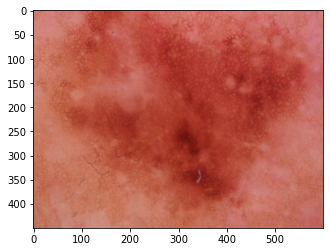

('nv', ' melanocytic nevi')
ISIC_0027417.jpg


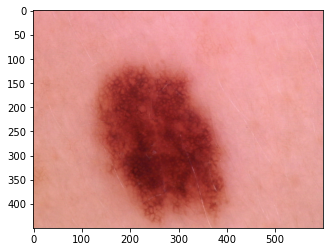

('nv', ' melanocytic nevi')
ISIC_0032420.jpg


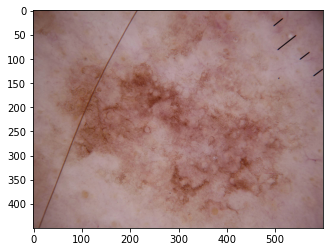

('nv', ' melanocytic nevi')
ISIC_0032873.jpg


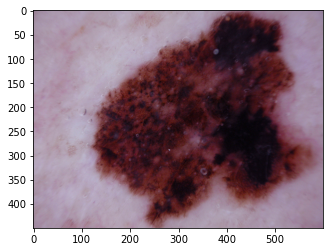

('bcc', ' basal cell carcinoma')
ISIC_0032046.jpg


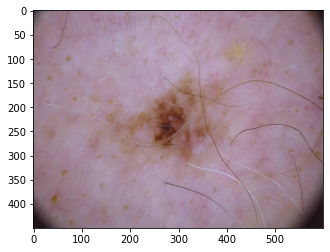

('akiec', 'Actinic keratoses and intraepithelial carcinomae')
ISIC_0025429.jpg


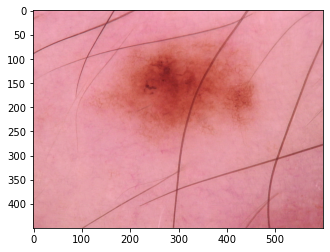

('nv', ' melanocytic nevi')
ISIC_0027487.jpg


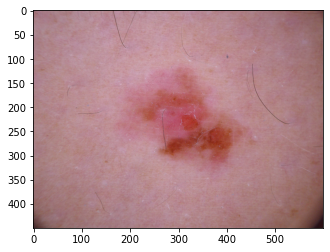

('nv', ' melanocytic nevi')
ISIC_0024375.jpg


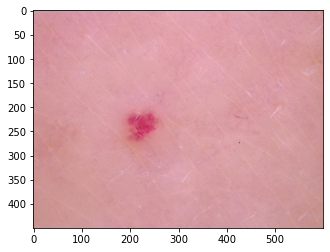

('nv', ' melanocytic nevi')
ISIC_0033511.jpg


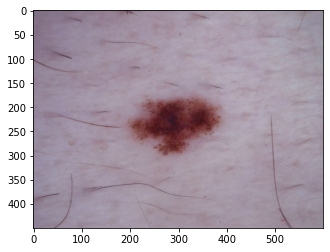

('bcc', ' basal cell carcinoma')
ISIC_0029879.jpg


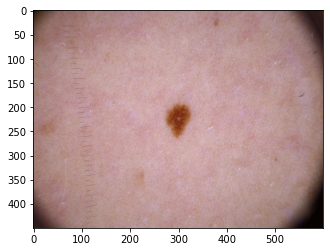

('nv', ' melanocytic nevi')


In [241]:
# sdir=r'drive/My Drive/HAZIQ/TESTTEST/MODELTEST/'
# flist=os.listdir(sdir)
# test_img=random.choice(flist)
# test_img=os.path.join(sdir, test_img)

for temp in range(0,10):
    img_name = random.choice(os.listdir(path))
    print(img_name)
#     img = random.choice([
#         x for x in os.listdir(path)
#         if os.path.isfile(os.path.join(path, x))
#         ])
 
    img = cv2.imread(os.path.join(path, img_name))
    #cv2.imwrite(temp, img)
    #cv2.imshow(img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    img = cv2.resize(img, (224, 224))
    result = model.predict(img.reshape(1, 224, 224, 3))
    max_prob = max(result[0])
    class_ind = list(result[0]).index(max_prob)
    class_name = classes[class_ind]
    print(class_name)
    

In [235]:
list_img=os.listdir(path)[:10]
list_img

['ISIC_0024306.jpg',
 'ISIC_0024307.jpg',
 'ISIC_0024308.jpg',
 'ISIC_0024309.jpg',
 'ISIC_0024310.jpg',
 'ISIC_0024311.jpg',
 'ISIC_0024312.jpg',
 'ISIC_0024313.jpg',
 'ISIC_0024314.jpg',
 'ISIC_0024315.jpg']

In [238]:
img_name = random.choice(list_img)
img_name

'ISIC_0024311.jpg'